
--- BƯỚC 1: HUẤN LUYỆN VÀ LƯU MÔ HÌNH ---
Đang huấn luyện mô hình...
Huấn luyện mô hình hoàn tất.
Mô hình đã được lưu vào: sales_prediction_model.pkl

Chỉ số đánh giá mô hình:
Sai số trung bình bình phương (RMSE): 105.36
Hệ số xác định (R-squared): 0.19

--- BƯỚC 2: PHÂN TÍCH HỆ SỐ MÔ HÌNH ---
Các đặc trưng đầu vào: ['City', 'Revenue', 'Quantity', 'Profit', 'Discount']

--- Hệ số của mô hình Linear Regression ---
Intercept (Hệ số chặn): -350.04
Coefficients (Hệ số của từng đặc trưng):
  cat__City_Aberdeen: -10.6953
  cat__City_Akron: 20.8562
  cat__City_Albuquerque: 7.4735
  cat__City_Alexandria: 29.8024
  cat__City_Allen: 15.9701
  cat__City_Allentown: -107.8218
  cat__City_Altoona: -121.2630
  cat__City_Amarillo: 35.1737
  cat__City_Anaheim: 20.3220
  cat__City_Andover: 52.9191
  cat__City_Ann Arbor: -19.0168
  cat__City_Antioch: -20.5884
  cat__City_Apopka: -85.8976
  cat__City_Apple Valley: 4.4623
  cat__City_Appleton: -40.8508
  cat__City_Arlington: -1.9116
  cat__City_Arlington 

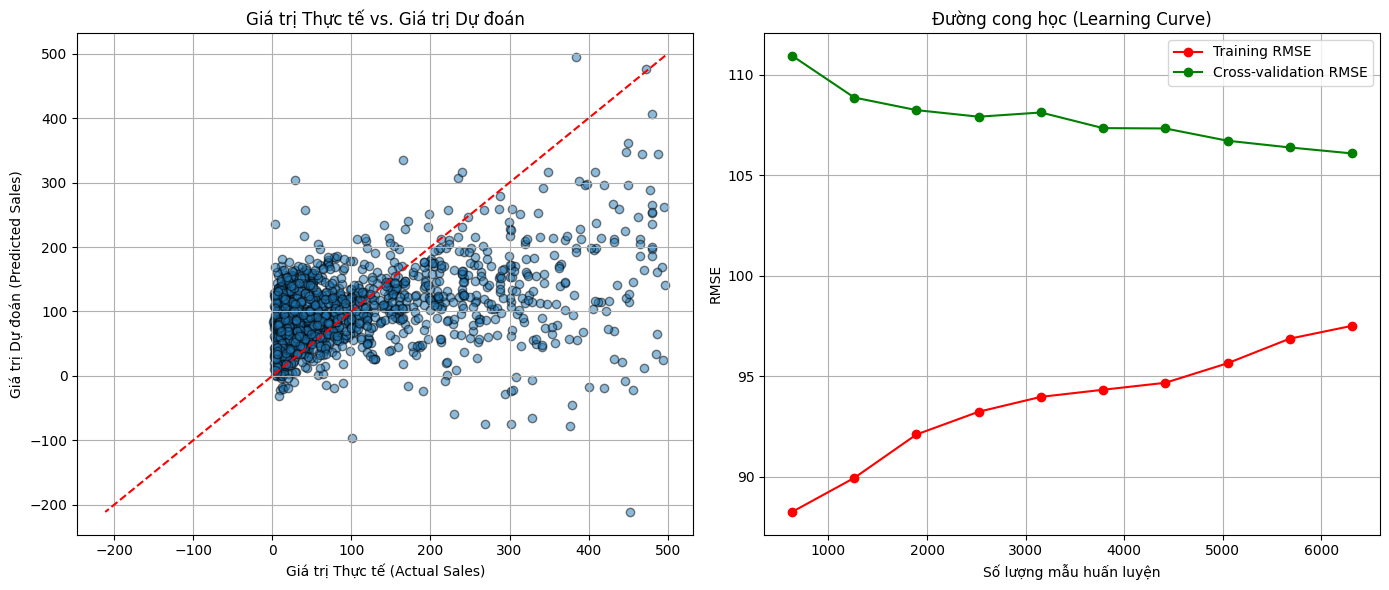

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve # CẬP NHẬT: Import learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import joblib
import matplotlib.pyplot as plt # CẬP NHẬT: Import thư viện vẽ biểu đồ

# ==============================================================================
# HÀM MỚI: DÙNG ĐỂ VẼ BIỂU ĐỒ TRỰC QUAN HÓA
# ==============================================================================
def plot_performance(y_true, y_pred, model_pipeline, X, y):
    """
    Vẽ 2 biểu đồ để đánh giá hiệu năng mô hình:
    1. So sánh giá trị thực tế và giá trị dự đoán.
    2. Đường cong học (Learning Curve) để kiểm tra overfitting.
    """
    print("\n--- BƯỚC 3: TRỰC QUAN HÓA VÀ KIỂM TRA OVERFITTING ---")

    # --- Biểu đồ 1: Giá trị Thực tế vs. Dự đoán ---
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.5, edgecolors='k')
    # Vẽ đường chéo y=x để so sánh
    p1 = max(max(y_true), max(y_pred))
    p2 = min(min(y_true), min(y_pred))
    plt.plot([p1, p2], [p1, p2], 'r--')
    plt.title('Giá trị Thực tế vs. Giá trị Dự đoán')
    plt.xlabel('Giá trị Thực tế (Actual Sales)')
    plt.ylabel('Giá trị Dự đoán (Predicted Sales)')
    plt.grid(True)

    # --- Biểu đồ 2: Đường cong học (Learning Curve) ---
    train_sizes, train_scores, test_scores = learning_curve(
        model_pipeline, X, y, cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10)
    )

    # Chuyển đổi điểm số (sai số âm) thành sai số dương (RMSE)
    train_rmse = np.sqrt(-train_scores.mean(axis=1))
    test_rmse = np.sqrt(-test_scores.mean(axis=1))

    plt.subplot(1, 2, 2)
    plt.plot(train_sizes, train_rmse, 'o-', color="r", label="Training RMSE")
    plt.plot(train_sizes, test_rmse, 'o-', color="g", label="Cross-validation RMSE")
    plt.title('Đường cong học (Learning Curve)')
    plt.xlabel('Số lượng mẫu huấn luyện')
    plt.ylabel('RMSE')
    plt.legend(loc="best")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# ==============================================================================
# CÁC HÀM CŨ CỦA BẠN (Không thay đổi)
# ==============================================================================
def train_sales_prediction_model(csv_file_path, model_output_path='sales_prediction_model.pkl'):
    """
    Huấn luyện mô hình và trả về các thành phần cần thiết để đánh giá.
    CẬP NHẬT: Trả về thêm y_test và y_pred để vẽ biểu đồ.
    """
    try:
        df = pd.read_csv(csv_file_path)
        features = ['City', 'Revenue', 'Quantity', 'Profit', 'Discount']
        target = 'Sales'

        if not all(col in df.columns for col in features + [target]):
            missing_cols = [col for col in features + [target] if col not in df.columns]
            print(f"Lỗi: Các cột sau không tìm thấy: {missing_cols}")
            return None

        X = df[features]
        y = df[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        preprocessor = ColumnTransformer(
            transformers=[
                ('cat', OneHotEncoder(handle_unknown='ignore'), ['City']),
                ('num', 'passthrough', ['Revenue', 'Quantity', 'Profit', 'Discount'])
            ])

        model_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', LinearRegression())
        ])

        print("Đang huấn luyện mô hình...")
        model_pipeline.fit(X_train, y_train)
        print("Huấn luyện mô hình hoàn tất.")

        joblib.dump(model_pipeline, model_output_path)
        print(f"Mô hình đã được lưu vào: {model_output_path}")

        y_pred = model_pipeline.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        print(f"\nChỉ số đánh giá mô hình:")
        print(f"Sai số trung bình bình phương (RMSE): {rmse:.2f}")
        print(f"Hệ số xác định (R-squared): {r2:.2f}")

        # CẬP NHẬT: Trả về X, y, y_test, y_pred
        return model_pipeline, features, rmse, r2, X, y, y_test, y_pred

    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy file tại đường dẫn: {csv_file_path}")
        return None
    except Exception as e:
        print(f"Đã xảy ra lỗi: {e}")
        return None

def load_sales_prediction_model(model_path='sales_prediction_model.pkl'):
    # ... (Hàm này giữ nguyên)
    try:
        model = joblib.load(model_path)
        print(f"Mô hình đã được tải từ: {model_path}")
        return model
    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy file mô hình tại đường dẫn: {model_path}")
        return None
    except Exception as e:
        print(f"Đã xảy ra lỗi khi tải mô hình: {e}")
        return None

# ==============================================================================
# PHẦN THỰC THI CHÍNH
# ==============================================================================
if __name__ == "__main__":
    csv_file = '/content/analyzed_data.csv' # Hãy đảm bảo đường dẫn này đúng
    model_file = 'sales_prediction_model.pkl'

    # --- BƯỚC 1: HUẤN LUYỆN VÀ LƯU MÔ HÌNH ---
    print("\n--- BƯỚC 1: HUẤN LUYỆN VÀ LƯU MÔ HÌNH ---")
    trained_model_info = train_sales_prediction_model(csv_file, model_file)

    if trained_model_info:
        # CẬP NHẬT: Nhận thêm các giá trị trả về
        model, features_used, rmse, r2, X_full, y_full, y_test_data, y_pred_data = trained_model_info

        print("\n--- BƯỚC 2: PHÂN TÍCH HỆ SỐ MÔ HÌNH ---")
        print(f"Các đặc trưng đầu vào: {features_used}")
        try:
            linear_reg_model = model.named_steps['regressor']
            feature_names_out = model.named_steps['preprocessor'].get_feature_names_out()
            coefficients = linear_reg_model.coef_
            intercept = linear_reg_model.intercept_

            print("\n--- Hệ số của mô hình Linear Regression ---")
            print(f"Intercept (Hệ số chặn): {intercept:.2f}")
            print("Coefficients (Hệ số của từng đặc trưng):")
            for feature_name, coef in zip(feature_names_out, coefficients):
                print(f"  {feature_name}: {coef:.4f}")
        except Exception as e:
            print(f"Không thể hiển thị hệ số mô hình chi tiết: {e}")

        # CẬP NHẬT: Gọi hàm vẽ biểu đồ
        plot_performance(y_test_data, y_pred_data, model, X_full, y_full)

# New Section